<a href="https://colab.research.google.com/github/starkjiang/TrAC-RL/blob/main/module2_rl_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grid World with Random Agent

In this tutorial, we implement the GridWorld environment and a random agent to show how we define state, action, and reward from scratch in a simple example. Please note that we will not implement any RL algorithms yet in this tutorial, while focusing primarily on the problem formulation. Instead, we can use OpenAI Gym environment to quikcly define the GridWorld env instead of developing from scratch. This tutorial is adapted from [GridWorld Reinforcement Learning](https://github.com/michaeltinsley/Gridworld-with-Q-Learning-Reinforcement-Learning-/tree/master).

The description of the environment is below. The tasks we will implement in this tutorial include:



1.   Create a GridWorld environment (5 X 5)
2.   Create a random agent
3.   Implement the random agent in the GridWorld environment
4.   Plot the mean total reward obtained by the agent through the episodes







In [ ]:
# Import necessary packages.
import matplotlib.pyplot as plt
import numpy as np
import operator
%matplotlib inline

# GridWorld Environment

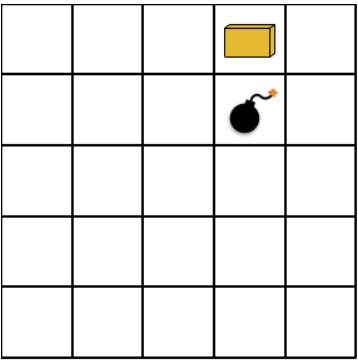

The agent has four possible actions in each state (grid square): up, down, lef, right. The actions are unreliable. If the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are terminal states. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state. In this tutorial, you will implement random walk for the policy. To define rewards, we will use the following reward function: -1 for each navigation action, an additional +10 for finding the gold, and an additional -10 for hitting the bomb. E.g., the immediate reward for transitioning into the square with the gold is -1+10=+9.



1.   The GridWorld class contains the environment
2.   The dimensions of the environment are defined
3.   Locations of all rewards are stored
4.   Functions for different methods written





In [ ]:
# Create GridWorld.
class GridWorld:
    """Base class for creating the GridWorld."""
    def __init__(self,
        height: int = 5,
        width: int = 5,
        bomb_location: tuple = (1, 3),
        gold_location: tuple = (0, 3),
    ):
        """Initialization."""
        # Set information about the gridworld
        self.height = height
        self.width = width
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = (4, np.random.randint(0, 5))

        # Set locations for the bomb and the gold
        self.bomb_location = bomb_location
        self.gold_location = gold_location
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    # Put methods here:
    def get_available_actions(self):
        """Returns possible actions."""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on
        the grid (used for debugging)."""
        grid = np.zeros((self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction.
        If agent is at a border, agent stays still but takes negative reward.
        Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (
                    self.current_location[0] - 1, self.current_location[1]
                )
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (
                    self.current_location[0] + 1, self.current_location[1]
                )
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (
                    self.current_location[0], self.current_location[1] - 1
                )
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (
                    self.current_location[0], self.current_location[1] + 1
                )
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb),
        if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

# Random Agent

Create a random agent to implement random walk.

In [ ]:
# Create a class for random agent.
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

# Q Learning Agent

Create an agent that performs Q Learning to reach the optimal policy for finding the gold with as few steps as possible while avoiding the bomb. The core of Q Learning is

$Q(s,a) = Q(s,a) + \alpha[r+\gamma\text{max}_aQ(s',a)-Q(s,a)]$

The entire pipeline is as follows (from Sutton & Barto (1998), Reinforcement Learning: An Introduction.)

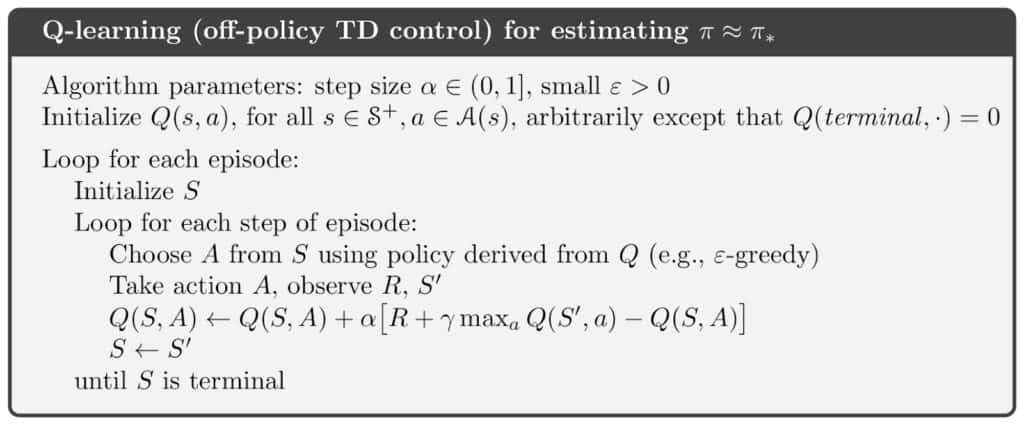

The detail of Q learning is as follows:
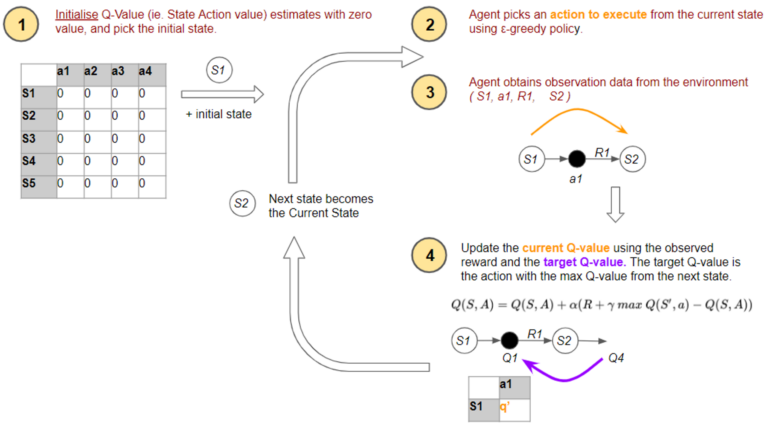

In [ ]:
# Create a class for Q agent. Since we only use Q learning, a Q table needs to
# be defined to store the state-action values.
class Q_Agent():
    # Class for Q agent.
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        # Initialize.
        self.environment = environment
        # Store all Q-values in dictionary of dictionaries.
        self.q_table = dict()
        # Loop through all possible grid spaces, create sub-dictionary for each
        for x in range(environment.height):
            for y in range(environment.width):
                # Populate sub-dictionary with zero values for possible moves
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0}

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table.
        If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        # TODO: Implement epsilon-greedy policy for the Q learning using an if
        # block.
        # If probability is less than the epsilon threshold, then explore.
        # Otherwise, implement the action that maximizes the Q value.
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[
                np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice(
                [k for k, v in q_values_of_state.items() if v == maxValue]
            )

        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        # TODO: Update the Q-value table using Q-learning.
        # Get the corresponding Q values of the new state.
        q_values_of_state = self.q_table[new_state]
        # Calculate the maximum Q value in the new state.
        max_q_value_in_new_state = max(q_values_of_state.values())
        # Get the current Q value.
        current_q_value = self.q_table[old_state][action]
        # Estimate the new Q value.
        esti_q_value = reward + self.gamma * max_q_value_in_new_state
        # Update the current Q value.
        self.q_table[old_state][action] = ((1 - self.alpha) * current_q_value
                                           + self.alpha * esti_q_value)


# Interaction between Anget and Env

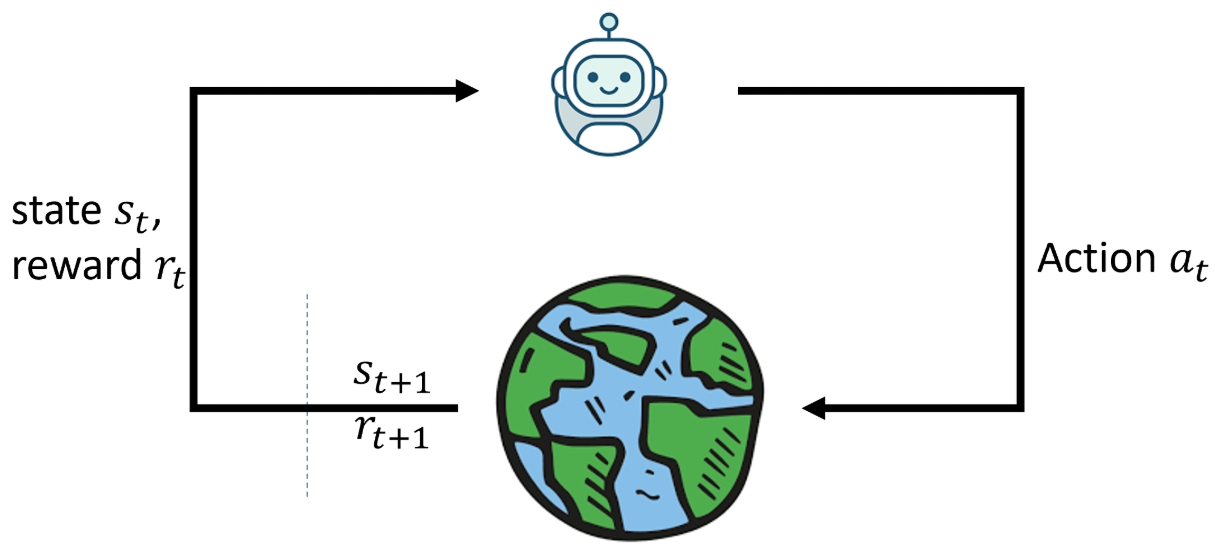

The interaction of the agent with its environments starts at decision stage at $t=0$ with the observation of the current state $s_0$. Note that there is no reward at the initial state. The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.

In [ ]:
# TODO: you can play with some hyperparameters to check the performance.
def play(
    environment,
    agent,
    trials = 500,
    max_steps_per_episode = 500,
    learn = False,
):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        # Run until max steps or until game is finished
        while step < max_steps_per_episode and game_over != True:
            # Set the old state based on the current location.
            old_state = environment.current_location
            # Execute the action.
            action = agent.choose_action(environment.actions)
            # Get the reward.
            reward = environment.make_step(action)
            # Get the new state.
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            # If game is in terminal state, game over and start next trial
            if environment.check_state() == 'TERMINAL':
                environment.__init__()
                game_over = True

        # Append reward for current trial to performance log
        reward_per_episode.append(cumulative_reward)

    # Return performance log
    return reward_per_episode

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


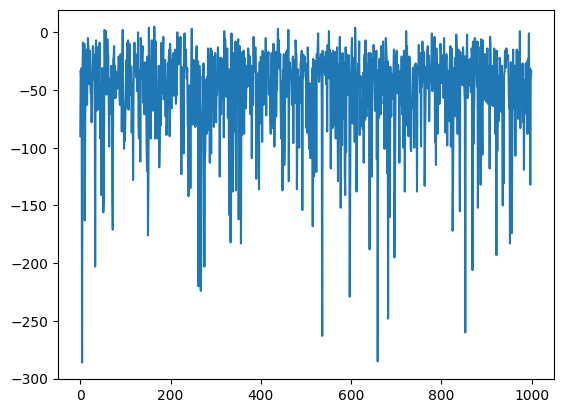

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=1000)

# Simple learning curve
plt.plot(reward_per_episode)

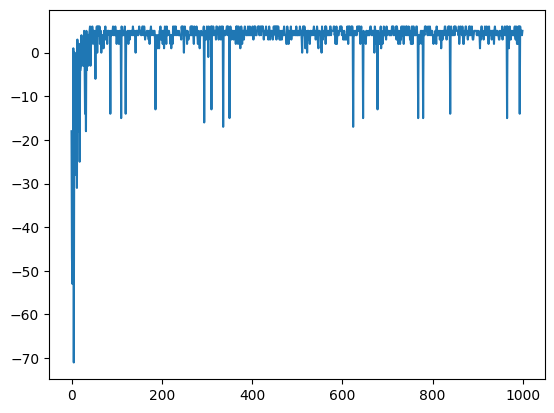

In [ ]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(
    environment,
    agentQ,
    trials=1000,
    learn=True
)

# Simple learning curve
plt.plot(reward_per_episode)